#### Process raw VR data to canonical
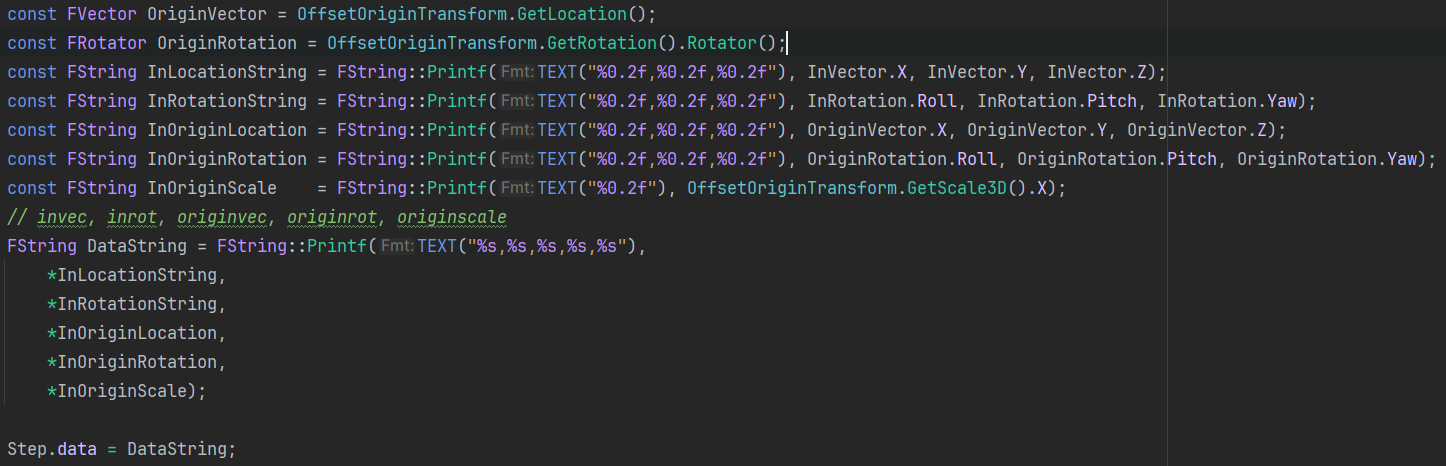

In [ ]:
# imports 
import cellworld_game as game
import cellworld as cw
import math
import os
from cellworld_game import CoordinateConverter 
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd

# Input log file
log_file = 'cellworld_vr_latest.log'
output_file = f"{log_file.split('.')[0]}_parsed.csv"


In [ ]:
import re


# Regex to extract frame number and X, Y values from lines like:
# [timestamp][thread]LogTemp: [AExperimentClient::UpdatePreyPosition] Sent frame: 2 | location: X=1324.329 Y=-237.742 Z=246.764
pattern = re.compile(r'frame:\s*(\d+)\s*\|\s*location:\s*X=([-+]?\d*\.\d+|\d+)\s*Y=([-+]?\d*\.\d+|\d+)', re.IGNORECASE)
anchor_pattern = re.compile(r'AnchorLocation([AB]):\s*X=([-+]?\d*\.\d+|\d+)\s*Y=([-+]?\d*\.\d+|\d+)', re.IGNORECASE)

# List to store extracted data
extracted_data = []

# Read the log file
with open(log_file, "r", encoding="utf-8") as file:
    content = file.read()

# Find all matches
matches = pattern.findall(content)
matches_anchor = anchor_pattern.findall(content)
# Save extracted data
with open(output_file, "w", encoding="utf-8") as out_file:
    out_file.write("Frame,X,Y\n")  # CSV Header
    for frame, x, y in matches:
        out_file.write(f"{frame},{x},{y}\n")
        extracted_data.append((frame, x, y))

# Output results
print(f"Extracted {len(extracted_data)} entries and saved to {output_file}")

if matches_anchor: 
    print(matches_anchor)
    originA_raw = [float(matches_anchor[0][1]), float(matches_anchor[0][2])]
    originB_raw = [float(matches_anchor[1][1]), float(matches_anchor[1][2])]

print(originA_raw)
print(originB_raw)

In [ ]:
# load file
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
# csv_file = output_file
csv_file = 'cellworld_vr_latest_parsed.csv'

# Read the CSV file
df = pd.read_csv(csv_file)
df.set_index(df.columns[0], inplace=True)

x_vals = df['X']
y_vals = df['Y']
df.head()

#### Test VRCoordinateConverter Class

In [ ]:
import cellworld_game as game

In [ ]:
import cellworld_game as game
class VRCoordinateConverter:
    def __init__(self):
        self.origin_transform = {'direction':None, 'scale': None}
        self.origin = {'entry':None, 'exit':None}
        self.active = False
        pass
    
    def set_origin(self, originA:list=None, originB:list=None, flipY:bool=True):
        self.origin['entry'] = [originA[1], -originA[0]] # flip x/y to y/-x
        self.origin['exit']  = [originB[1], -originB[0]] # flip x/y to y/-x
        self.origin_transform['direction'] = game.Direction.radians(self.origin['entry'], self.origin['exit']) + (np.pi/2)
        self.origin_transform['scale']     = game.Point.distance(self.origin['entry'] ,  self.origin['exit'])
        self.active = True
        print(f'[set origin] Active: {self.active}')
        print(f'[set origin] Origin: {self.origin}')
        print(f'[set origin] Origin Tranform: {self.origin_transform}')
    
    def vr_to_canonical(self,x,y)->game.Point:

        dirp = game.Direction.radians(self.origin['entry'], (x,y)) - self.origin_transform['direction']
        distp = game.Point.distance(self.origin['entry'],(x,y)) / self.origin_transform['scale'] 
        point = game.Point.move((0, .5), distance=distp, direction_radians=dirp)         
        
        # y = point[1]*math.sqrt(3)*0.5  + 0.5 - (math.sqrt(3)/4) 
        offset = (1-math.sqrt(3)*0.5)
        magic_num = 0.0275
        p = (point[0]+magic_num, point[1] - offset - magic_num)
        return p
    
    def canonical_to_vr(self, px, py) -> game.Point:
        direction = game.Direction.radians((0, 0.5), (px, py)) + self.origin_transform['direction'] 
        distance = game.Point.distance((0, 0.5), (px, py)) * self.origin_transform['scale']
        return game.Point.move(self.origin['entry'], distance=distance, direction_radians=direction)  

In [ ]:
vrcc = VRCoordinateConverter()
vrcc.set_origin(originA=originA_raw, originB=originB_raw)
drotated_points_vcc = []
dunrotated_points_vcc = []
idx = 0
for x, y in zip(x_vals, y_vals):
  pc = vrcc.vr_to_canonical(x,y)
  pvr = vrcc.canonical_to_vr(pc[0],pc[1])
  # print(f'xvr: {x:0.2f}, xvr->xc: {pc[0]:0.2f} | xc->xvr {pvr[0]:0.2f} | error: {x-pvr[0]:0.2f}')
  # print(f'yvr: {y:0.2f}, yvr->xc: {pc[1]:0.2f} | yc->yvr {pvr[1]:0.2f} | error: {y-pvr[1]:0.2f}')
  drotated_points_vcc.append(pc)
  dunrotated_points_vcc.append(pvr)
  idx +=1 

drotated_points_vcc = np.array(drotated_points_vcc)

#### Plot Raw data (trajectory is entry to exit door)

In [ ]:
w = cw.World.get_from_parameters_names("hexagonal", "canonical", "21_05")
dis = cw.Display(w,fig_size=(4,4))
# plt.figure(figsize=(5,5))
# plt.plot(dunrotated_points_vcc[:, 0], dunrotated_points_vcc[:, 1], linewidth=1.5,label='v2')

plt.plot(drotated_points_vcc[:, 0], drotated_points_vcc[:, 1], linewidth=1.5,label='v1')
plt.legend()